In [1]:

import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


C:\Users\gwgwa\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [2]:

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [3]:
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.renameArguments(ARG0='x')

In [4]:
pset.addPrimitive(np.positive, arity=1)
pset.addPrimitive(np.sin, arity=1)

In [5]:

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [6]:
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
    return (np.sqrt(np.sum(sqerrors) / len(points)),)

In [7]:

toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [8]:

toolbox.register("insert" , gp.mutInsert, pset=pset)

In [9]:

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [10]:
gen = range(40)
avg_list = []
max_list = []
min_list = []

pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 0.5056866194019045
  Max 1.765081605748411
  Avg 0.9276234185153623
  Std 0.1967682186238916
-- Generation 1 --
  Min 0.3185682254736571
  Max 1.913330089660416
  Avg 0.8874437565911175
  Std 0.22494185101349476
-- Generation 2 --
  Min 0.3185682254736571
  Max 2.5909294086996884
  Avg 0.8219030499132729
  Std 0.260413381307061
-- Generation 3 --
  Min 0.3185682254736571
  Max 2.2799741419732835
  Avg 0.7671338272532925
  Std 0.2765045313127418
-- Generation 4 --
  Min 0.3067764218027227
  Max 1.7126422086298008
  Avg 0.7056269902456266
  Std 0.3053717708341314
-- Generation 5 --
  Min 0.15928411273179102
  Max 2.1134173679263952
  Avg 0.6418475169036404
  Std 0.31560370892260264
-- Generation 6 --
  Min 0.15928411273179102
  Max 1.6979873012312805
  Avg 0.621074597574983
  Std 0.3237042759650816
-- Generation 7 --
  Min 0.159284112731791
  Max 2.7738735050143437
  Avg 0.5639336440005711
  Std 0.31320439031583364
-- Generation 8 --
  Min 0.1341547138992929
  Ma

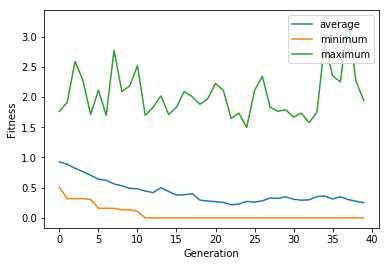

In [11]:
%matplotlib inline
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()